In this notebook we will be building a simple model to estimate the median housing prices given the California Housing Prices dataset. This dataset was based on the 1990 California consensus.

In [1]:
#Imports
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


# Exploratory Data Analysis

In [2]:
#Read in the dataset
housing = pd.read_csv('./Data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


So the target we are trying to predict is **median_house_value** and all of the other features are our input attributes.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Luckily for us, the dataset seems relatively complete, however, we can see that **total_bedrooms** has 207 missing values. We will need to decide to either remove the 207 rows from our dataset or somehow fill in this missing information (use the mean value as a placeholder?)

Another thing to note is that all of the attributes are numerical except for the **ocean_proximity** feature. As we know, machine learning algorithms expect numerical features. Therefore, if we want to use this feature column we need to transform this feature into numerics.

In [4]:
#Checking to see unique values of 'ocean_proximity' feature
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

So the **ocean_proximity** feature is a categorical attribute. We could represent this feature numerically by assigning a number to a specific category. 

Example: (0 = INLAND, 1 = NEAR OCEAN, 2 = NEAR BAY, 3 = ISLAND)

In [5]:
#Take a look at the statistics of our dataset
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


So something strange we can see from this table is the **median_income** attribute. It doesn't seem to be represented in dollars because the maximum value is 15. This probably means that the data was normalized between 0 - 15. **median_house_value** and **housing_median_age** also seem to be normalized to certain values. We must keep in mind that training on this dataset will give us normalized **median_house_value** which is not in dollars.

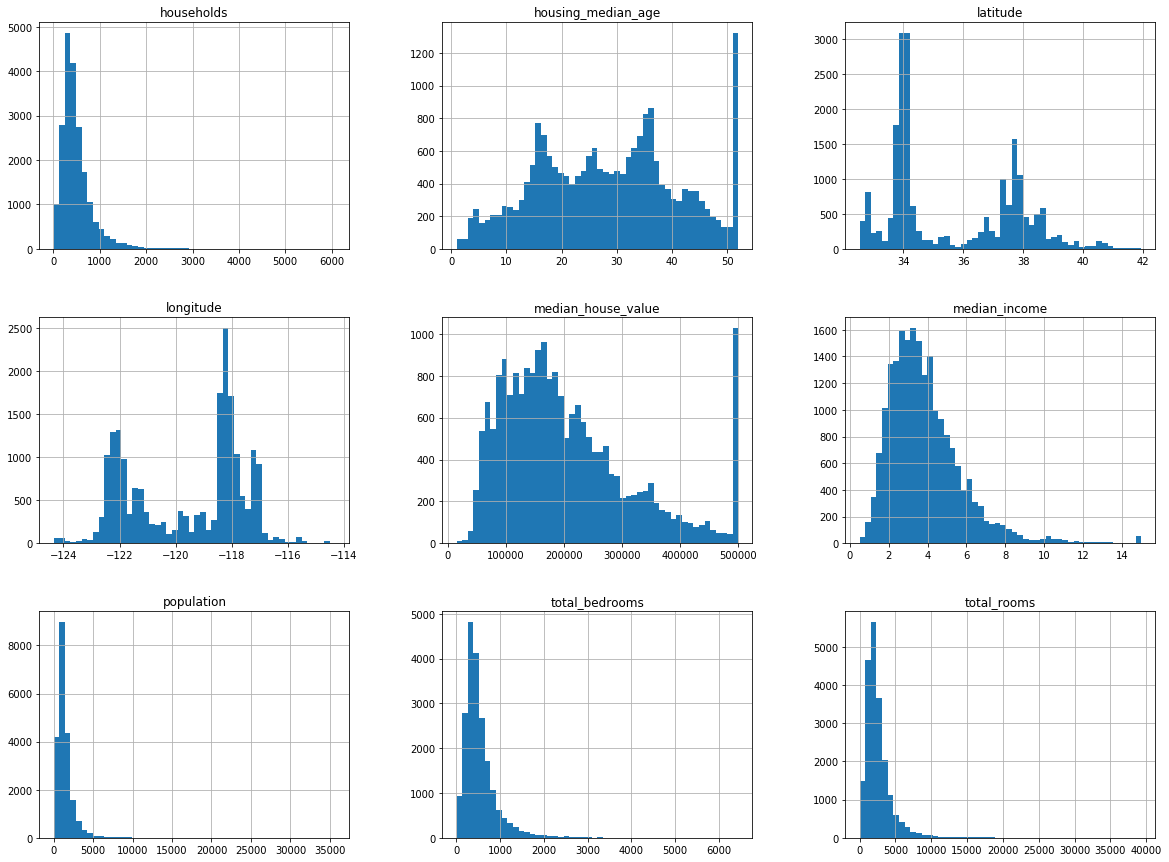

In [6]:
#Take a look at the histograms of our dataset
housing.hist(bins=50, figsize=(20,15))
plt.show()

Looking at the histograms, we can see that a lot of the data is heavily skewed. This can make it harder for some machine learning algorithms to make predictions. We might need to transform this data to have a more bell shaped distribution (i.e. normal distribution)

# Train/Test Split:

Usually, a random train/test split method works well for large datasets. But this is not always the case, consider for example a survey company that chooses 1000 people at random to ask a few questions. The company wants to ensure that the 1000 people represent the whole population. But, in general the Canadian population is composed of 53% femalse and 47% males. So, sampling a random 1000 people without consideration of this ratio could skew the results. This is called **sampling bias**.

In our example, we will perform sampling by attempting to maintain the ratio of **median_income**. That is, most people have an income of 2-5 but some are well 6+. Since **median_income** is a continous numerical number, we need to bucketize this attribute before we can sample correctly. We will bucketize this attribute into 5 categories and then perform a train/test split trying to maintain this ratio in both training data and testing data.

In [7]:
#Bucketize median_income
housing["income_category"] = np.ceil(housing['median_income'] / 1.5)
housing["income_category"].where(housing["income_category"] < 5, 5.0, inplace=True)

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now that we split the training and testing data, let us check to see if the ratio was maintained.

In [10]:
#Check the ratio of the original dataset
housing['income_category'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64

In [11]:
#Check the ratio of the training set
strat_train_set['income_category'].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_category, dtype: float64

In [12]:
#Check the ratio of the teingst set
strat_test_set['income_category'].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_category, dtype: float64

In [13]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_category'], axis=1, inplace=True)

# Data Visualization

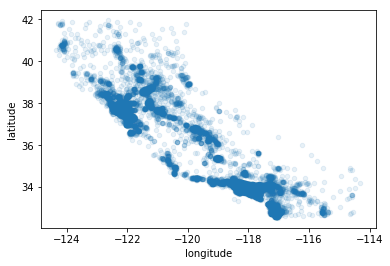

In [14]:
#Create a copy of the training data
housing = strat_train_set.copy()

#Visualize the longitude and latitude
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

So this definitely looks like california, moreover there seems to be a large density in some regions, specifically around San Diego and Los Angelos. Lets create another visualization that shows us which area in california has the most expensive houses.

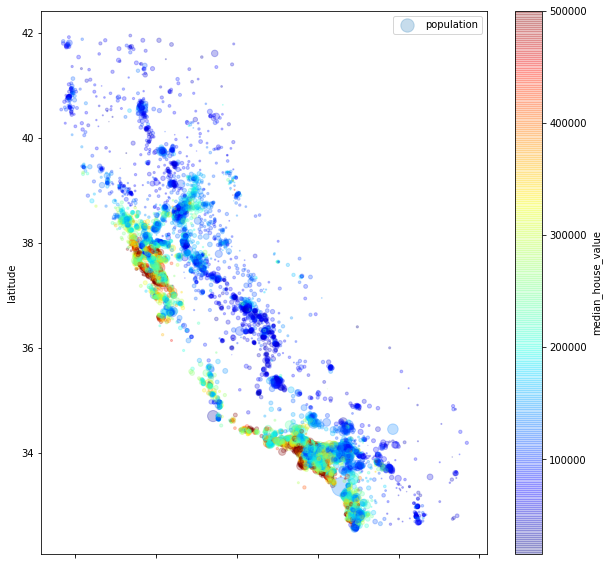

In [15]:

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.25,
            s=housing['population']/100, c='median_house_value', label="population", 
            cmap='jet', colorbar=True, figsize=(10,10))
plt.legend()
plt.show()

So from this plot we can see clearly that housing price is very much related to location. Houses located near the coast are much more expensive. Also, population density seems to correlate with housing price as well.

Next we will take a look at the correlation between the attributes. We want to see the relationships between attributes. If two attributes are heavily correlated, perhaps we could remove one of those attributes when fitting our machine learning model, since they are basically giving the same information.

In [16]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way of visualizing correlation is to simply scatter plot the attributes together and see the pattern. Since our dataset has 11 attributes. There are a total of 121 scatter plots we could visualize, however we are just going to look at the ones with strong correlation to our target attribute, **median_house_value**.

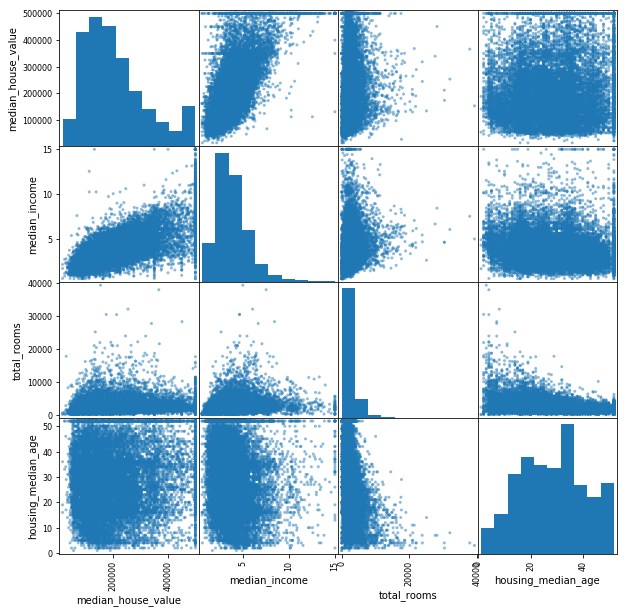

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(10,10))
plt.show()

# Feature Engineering:

I will create new features like "rooms_per_household", "bedrooms_per_room", "population_per_household" because these features are typically what people are looking for when shopping for houses. They could tell us a little bit more about the average house prices.

In [18]:
housing["rooms_per_houshold"] = housing['total_rooms'] / housing["households"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_rooms"] / housing["total_bedrooms"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
bedrooms_per_room           0.385271
rooms_per_houshold          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

By looking at the correlation matrix, we can see that the new features we just created have some correlation to the **median_house_value**.

# Data Cleaning:

In [19]:
#Start with a clean slate of the data:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Filling in Missing Features:

Earlier we noticed that the **total_bedrooms** attribute had some missing data. Machine learning algorithms typically do not like missing features so we need a way to fill in this data. Typically, you have three options to handle missing features:
- Get rid of the entire attribute (remove the column)
- Get rid of the data entries (remove the rows with missing data)
- Fill in the missing data with some value (zero, mean, median)

In [26]:
#Fill in the missing data with the median
from sklearn.impute import SimpleImputer

#Imputer Object
imputer = SimpleImputer(strategy="median")

#Drop the ocean_proximity attribute since a median cannot be computed on text
housing_num = housing.drop("ocean_proximity",axis=1)

#Calculate the median for all attributes
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
#Use the imputer to fill in missing data
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


## Handling Text and Categorical Attributes:

As we saw earlier **ocean_proximity** is a text attribute. Machine Learning algorithms require that the input be numerical, so we will convert the text categories to numerical categories.

In [33]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
housing_cat_1hot.shape

(16512, 5)

## Custom Transformers:

In order to create custom transformers that work well with sklearn's functionalities, we need to create a custom transformer and implement three methods: fit(), transform(), and fit_transform(). Custom transformers are very useful when you want to perform your data cleaning in steps, like a pipeline.

In [34]:
#Create a custom transformer class
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household = X[:,population_ix] / X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [41]:
#Use the custom transformer to create new attributes
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_atribs = attr_adder.transform(housing.values)

#Column Names
columns = ["longitude", "latitude", "housing_median_age", "total_rooms",
          "total_bedrooms", "population", "households", "median_income",
          "ocean_proximity", "rooms_per_household", "population_per_household"]

#Create Pandas Dataframe with Extra Attributes
housing_extra_atribs_df = pd.DataFrame(housing_extra_atribs, columns = columns)
housing_extra_atribs_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Feature Scaling:

The input attributes have very different scales. Most machine learning algorithms perform better when the numerical values are within the same scale. There are two ways to get the attributes to all have the same scale:
- min-max scaling
- standardization

Min-max scaling (or normalization) is taking all the numerical values and squashing them between 0 and 1. We do this by subtracting the min value and dividing by the max minus the min. Sklearn provides this functionality in their MinMaxScaler class.

Standardization first subtracts each value by its mean and then divides by the variance. The result is data with zero mean and a unit variance distribution. Standardization is much less affected by outliers.

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(housing_num)
housing_scaled = scaler.transform(housing_num)
housing_scaled.shape

columns = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]
housing_scaled = pd.DataFrame(housing_scaled,columns=columns)
housing_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.635400e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.353107e-15,2.284564e-15,-4.701235e-17,7.587062e-17,1.595343e-17,-3.700743e-17,2.078979e-17,-2.102108e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.291474e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.814921e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.470978e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.641863e-01,2.684162e-01,2.793106e-01,4.561338e-01
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.375142e+01,3.071047e+01,1.293803e+01,5.839969e+00


As you can see, we successfully standardized the input data (the data now has a mean of ~0 and std of ~1).

# Transformation Pipelines:

Often times there are a list of steps we would like to do for data cleaning. Sklearn provides a pipeline that can be used for datapreprocessing, automated way for us to perform data cleaning. After setting up the pipeline, we can simply call it on the data we wish to process. Additionally, we seperate the data preprocessing into steps and if we wish to make a change, we can simply change a part of the pipeline. It is a good way to organize your data preprocessing procedures.